In [55]:
# !pip install hyperopt --user

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm

# Import necessary libraries
from hyperopt import fmin, tpe, hp
from hyperopt import Trials
from hyperopt import space_eval
from sklearn.model_selection import cross_val_score

In [102]:
pd.set_option("max_column", None)

In [142]:
# Load the dataset
df = pd.read_csv('airlines_delay.csv')
# Display first few rows of the dataset
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [83]:
# Get general statistics of the dataset

df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [84]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64


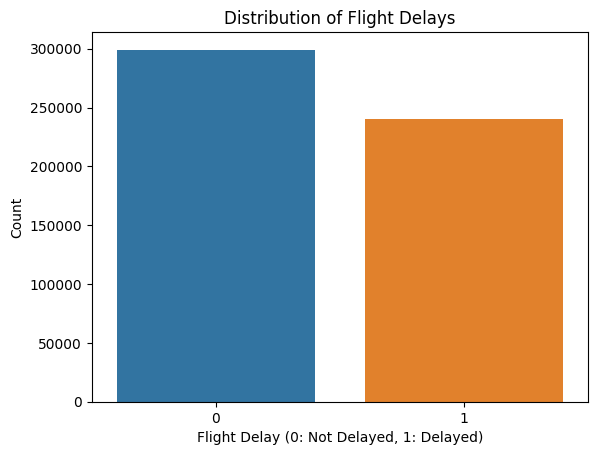

In [85]:
# Explore distribution of Class (target variable)
sns.countplot(x='Class', data=df)
plt.xlabel('Flight Delay (0: Not Delayed, 1: Delayed)')
plt.ylabel('Count')
plt.title('Distribution of Flight Delays')
plt.show()

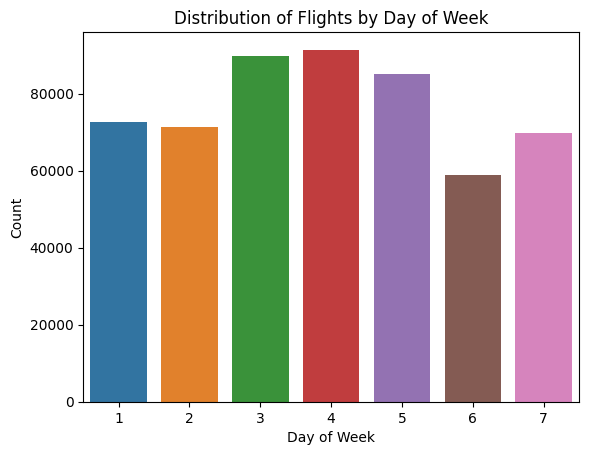

In [86]:
# Explore distribution of DayOfWeek
sns.countplot(x='DayOfWeek', data=df)
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Distribution of Flights by Day of Week')
plt.show()

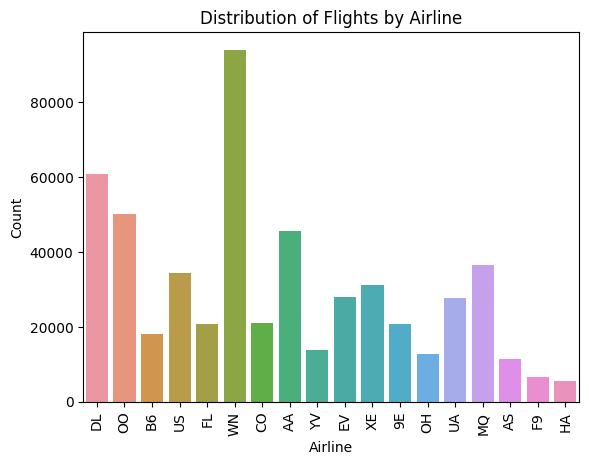

In [87]:
# Explore distribution of Airline
sns.countplot(x='Airline', data=df)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Distribution of Flights by Airline')
plt.xticks(rotation=90)
plt.show()

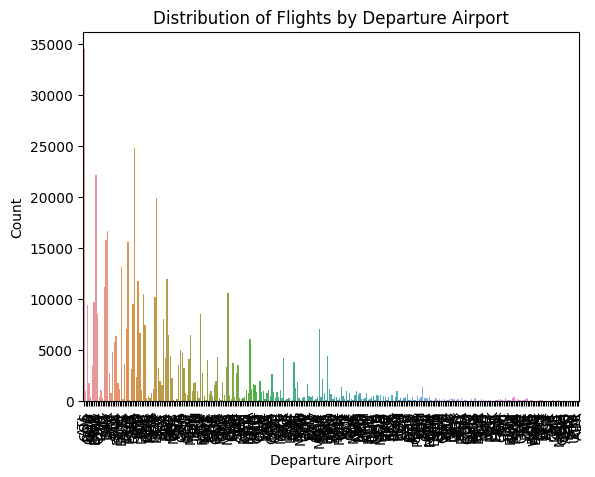

In [88]:
# Explore distribution of AirportFrom
sns.countplot(x='AirportFrom', data=df)
plt.xlabel('Departure Airport')
plt.ylabel('Count')
plt.title('Distribution of Flights by Departure Airport')
plt.xticks(rotation=90)
plt.show()

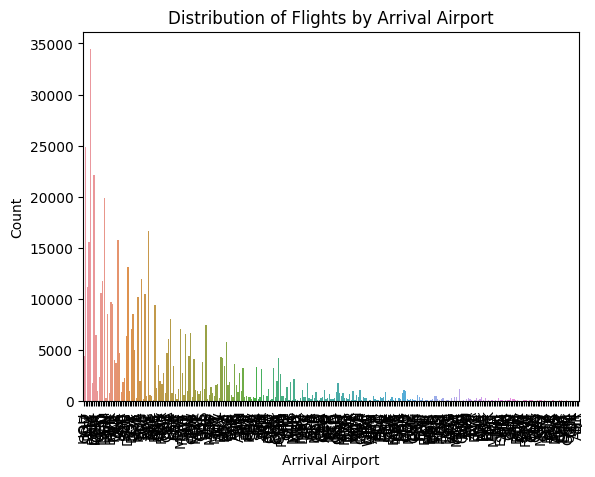

In [89]:
# Explore distribution of AirportTo
sns.countplot(x='AirportTo', data=df)
plt.xlabel('Arrival Airport')
plt.ylabel('Count')
plt.title('Distribution of Flights by Arrival Airport')
plt.xticks(rotation=90)
plt.show()

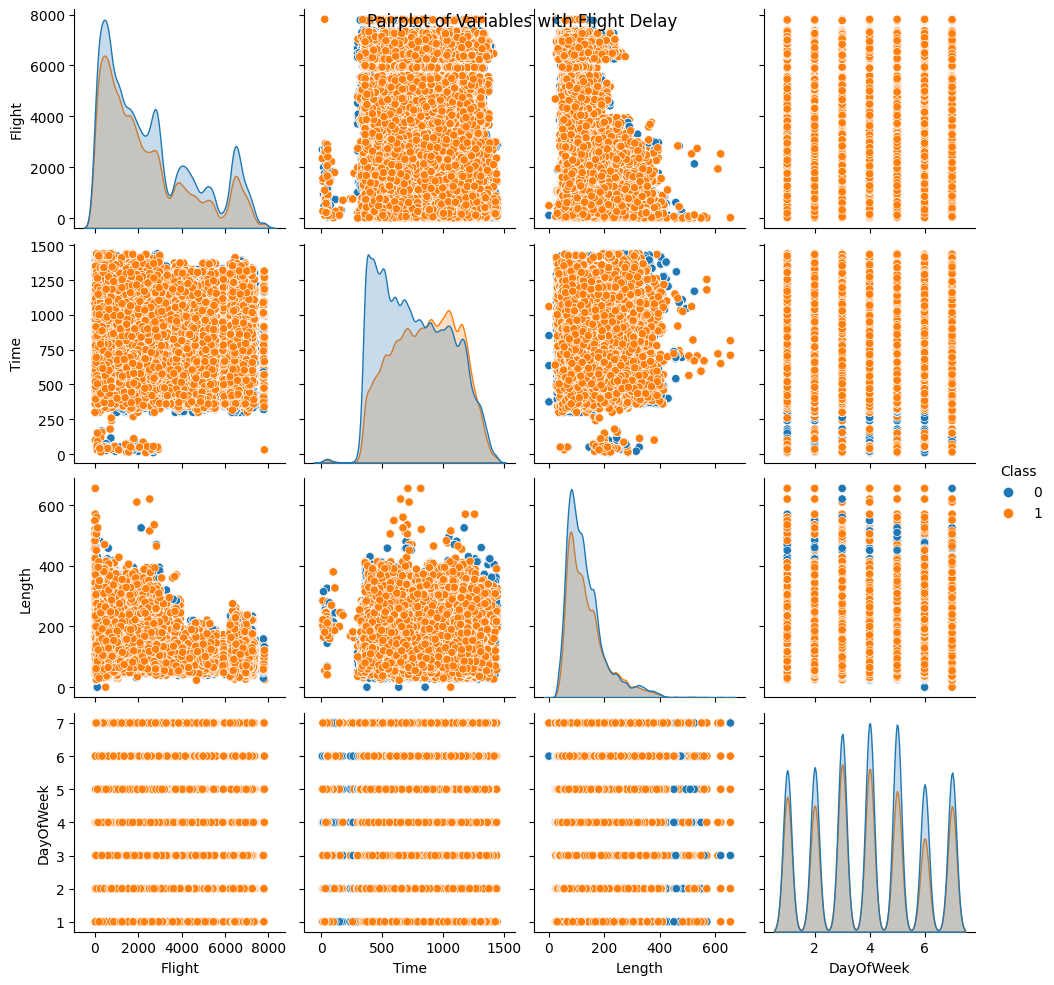

In [11]:
# Explore interactions between variables
sns.pairplot(df, hue='Class', diag_kind='kde')
plt.suptitle('Pairplot of Variables with Flight Delay')
plt.show()

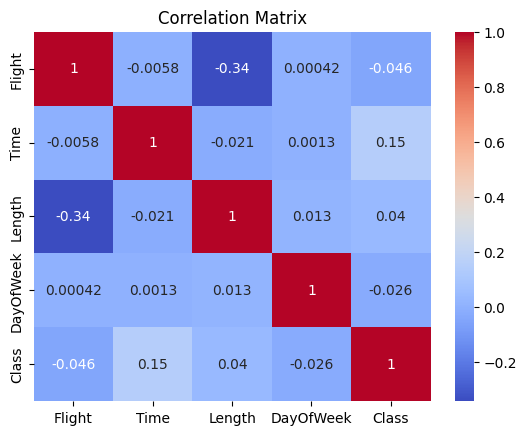

In [90]:
# Calculate correlation matrix
corr = df.corr()

# Plot correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [143]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [144]:
# Create aggregated features
# Aggregating data to the level of the airline
airline_agg = df.groupby('Airline').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
   # 'Class': 'mean'
}).reset_index()
# Rename columns
airline_agg.columns = ['Airline', 'AirlineAvgLength', 'AirlineMinLength', 'AirlineMaxLength', 'AirlineNumFlights']
airline_agg

,Airline,AirlineAvgLength,AirlineMinLength,AirlineMaxLength,AirlineNumFlights
0,9E,96.690660,39.0,190.0,20686
1,AA,172.331128,50.0,560.0,45656
2,AS,171.513992,24.0,413.0,11471
3,B6,171.738737,0.0,406.0,18112
4,CO,193.497822,44.0,655.0,21118
5,DL,157.520479,49.0,620.0,60940
6,EV,91.424222,39.0,221.0,27983
7,F9,151.437887,0.0,272.0,6456
8,FL,131.773899,57.0,345.0,20827
9,HA,93.841341,30.0,405.0,5578


In [145]:
# Aggregating data to the level of the airport
airport_agg = df.groupby('AirportFrom').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
    #'Class': 'mean'
}).reset_index()

# Rename columns
airport_agg.columns = ['AirportFrom', 'AirportFromAvgLength', 'AirportFromMinLength', 'AirportFromMaxLength', 'AirportFromNumFlights']
airport_agg

,AirportFrom,AirportFromAvgLength,AirportFromMinLength,AirportFromMaxLength,AirportFromNumFlights
0,ABE,134.654971,106.0,178.0,342
1,ABI,50.639810,50.0,55.0,211
2,ABQ,112.224723,50.0,223.0,2799
3,ABR,76.000000,76.0,76.0,2
4,ABY,56.632184,50.0,61.0,87
...,...,...,...,...,...
288,VPS,99.488152,69.0,140.0,633
289,WRG,31.881356,24.0,40.0,59
290,XNA,104.921986,66.0,180.0,1128
291,YAK,49.368421,46.0,52.0,57


In [146]:
# Aggregating data to the level of the route
df['Route'] = df['AirportFrom'] + '-' + df['AirportTo']
route_agg = df.groupby('Route').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
    #'Class': 'mean'
}).reset_index()
# Rename columns
route_agg.columns = ['Route', 'RouteAvgLength', 'RouteMinLength', 'RouteMaxLength', 'RouteNumFlights']
route_agg

,Route,RouteAvgLength,RouteMinLength,RouteMaxLength,RouteNumFlights
0,ABE-ATL,153.032258,145.0,163.0,31
1,ABE-CLT,106.000000,106.0,106.0,31
2,ABE-DTW,112.588235,110.0,115.0,85
3,ABE-FLL,178.000000,178.0,178.0,17
4,ABE-MCO,156.000000,156.0,156.0,31
...,...,...,...,...,...
4185,YAK-CDV,52.000000,52.0,52.0,29
4186,YAK-JNU,46.642857,46.0,48.0,28
4187,YUM-IPL,27.000000,27.0,27.0,31
4188,YUM-LAX,79.319328,77.0,80.0,119


In [147]:
# Merge the aggregated features back to the original dataset
df = pd.merge(df, airline_agg, on='Airline', how='left')
df = pd.merge(df, airport_agg, on='AirportFrom', how='left')
df = pd.merge(df, route_agg, on='Route', how='left')

In [148]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Route,AirlineAvgLength,AirlineMinLength,AirlineMaxLength,AirlineNumFlights,AirportFromAvgLength,AirportFromMinLength,AirportFromMaxLength,AirportFromNumFlights,RouteAvgLength,RouteMinLength,RouteMaxLength,RouteNumFlights
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0,ATL-HOU,157.520479,49.0,620.0,60940,119.993875,40.0,620.0,34449,141.539106,132.0,159.0,358
1,6948.0,360.0,146.0,OO,COS,ORD,4,0,COS-ORD,93.604847,23.0,244.0,50254,107.112512,40.0,194.0,1031,146.585938,146.0,158.0,128
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0,BOS-CLT,171.738737,0.0,406.0,18112,166.813116,0.0,418.0,9439,144.815864,135.0,152.0,353
3,31.0,1410.0,344.0,US,OGG,PHX,6,0,OGG-PHX,147.043507,48.0,412.0,34500,143.848194,32.0,476.0,1772,344.000000,344.0,344.0,47
4,563.0,692.0,98.0,FL,BMI,ATL,4,0,BMI-ATL,131.773899,57.0,345.0,20827,99.017284,50.0,142.0,405,105.124464,98.0,115.0,233


In [149]:
# Select columns with data type 'object'
object_cols = df.select_dtypes(include='object').columns.tolist()
print(object_cols)

from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

for i in object_cols:
    # Apply label encoding to a specific column in the dataframe
    df[i] = label_encoder.fit_transform(df[i])

['Airline', 'AirportFrom', 'AirportTo', 'Route']


In [150]:
# Extract features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
# Train and evaluate XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [152]:
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print('XGBoost Accuracy:', xgb_acc)

XGBoost Accuracy: 0.6672413952927871


In [154]:
# Train and evaluate CatBoost model
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train, y_train, verbose=False)

In [155]:
catboost_pred = catboost_model.predict(X_test)
catboost_acc = accuracy_score(y_test, catboost_pred)
print('CatBoost Accuracy:', catboost_acc)

CatBoost Accuracy: 0.6719968111831067


In [156]:
# Train and evaluate LightGBM model
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [157]:
lgbm_pred = lgbm_model.predict(X_test)
lgbm_acc = accuracy_score(y_test, lgbm_pred)
print('LightGBM Accuracy:', lgbm_acc)

LightGBM Accuracy: 0.6622078849059577


In [158]:
# Identify important features
xgb_importance = xgb_model.feature_importances_
catboost_importance = catboost_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_

In [159]:
# Print feature importances
print('XGBoost Feature Importances:', xgb_importance)
print('CatBoost Feature Importances:', catboost_importance)
print('LightGBM Feature Importances:', lgbm_importance)


XGBoost Feature Importances: [0.00883181 0.04047881 0.00794314 0.03209124 0.01280435 0.01410187
 0.00971868 0.01528947 0.03367887 0.06366847 0.07506897 0.5163334
 0.01953308 0.01702589 0.02606281 0.03356154 0.02323361 0.01806396
 0.02061165 0.01189834]
CatBoost Feature Importances: [ 4.89452664 16.67599611  3.92748721  3.95191707  2.23542847  5.13734524
  5.96677878  2.62760466  1.80788572  2.82610636  3.31198655 20.14730978
  4.37832027  2.8938272   3.9482252   4.65849757  2.36077844  1.88561101
  2.28847072  4.07589703]
LightGBM Feature Importances: [161 363 126 131 147 197 231  89 109  99  55 121 209 133 175 214  80  79
 113 168]


In [160]:
# Evaluate model performance
def evaluate_model_performance(y_true, y_preds, model, split):
    model_name = type(model).__name__
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    return pd.Series({'Model': model_name,
                      'Train/Test': split,
                      'Accuracy': accuracy,
                      'Precision': precision,
                      'Recall': recall,
                      'F1 Score': f1})

In [161]:
# Create a DataFrame to store the evaluation metrics
results_df = pd.DataFrame(columns=['Model', 'Train/Test', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df = results_df.append(evaluate_model_performance(y_train, xgb_model.predict(X_train), xgb_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, xgb_pred, xgb_model, 'Test'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_train, catboost_model.predict(X_train), catboost_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, catboost_pred, catboost_model, 'Test'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_train, lgbm_model.predict(X_train), lgbm_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, lgbm_pred, lgbm_model, 'Test'), ignore_index=True)

In [199]:
results_df.T

,0,1,2,3,4,5
Model,XGBClassifier,XGBClassifier,CatBoostClassifier,CatBoostClassifier,LGBMClassifier,LGBMClassifier
Train/Test,Train,Test,Train,Test,Train,Test
Accuracy,0.682799,0.667241,0.687035,0.671997,0.666064,0.662208
Precision,0.689252,0.668433,0.691592,0.671636,0.677228,0.673248
Recall,0.523516,0.505346,0.536051,0.519133,0.477462,0.472936
F1 Score,0.595059,0.57556,0.603968,0.585619,0.560065,0.555588


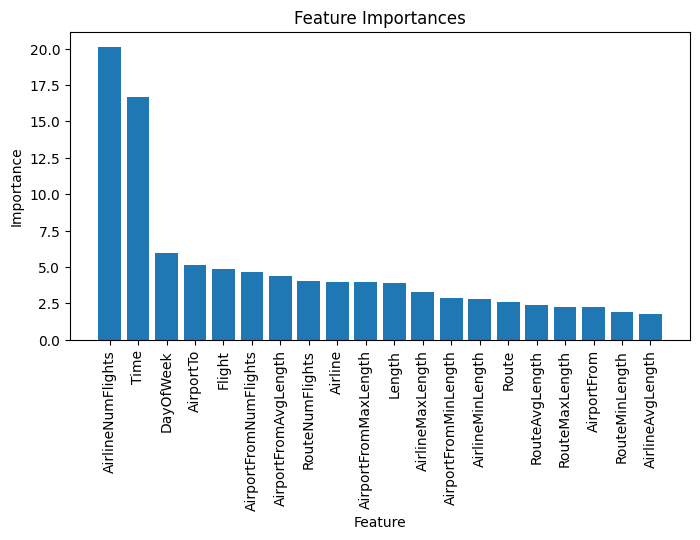

In [204]:
# Get feature importances
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_names)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [164]:
feat = dict(zip(feature_names, feature_importances))
feat

{'Flight': 4.894526639544989,
 'Time': 16.675996109299334,
 'Length': 3.9274872060883457,
 'Airline': 3.951917069050404,
 'AirportFrom': 2.2354284652457985,
 'AirportTo': 5.13734524138616,
 'DayOfWeek': 5.966778782912461,
 'Route': 2.6276046567984954,
 'AirlineAvgLength': 1.8078857191651552,
 'AirlineMinLength': 2.826106361693833,
 'AirlineMaxLength': 3.311986546541471,
 'AirlineNumFlights': 20.14730978173121,
 'AirportFromAvgLength': 4.378320267877269,
 'AirportFromMinLength': 2.8938271956283854,
 'AirportFromMaxLength': 3.948225197403126,
 'AirportFromNumFlights': 4.6584975661726356,
 'RouteAvgLength': 2.3607784404023358,
 'RouteMinLength': 1.885611008089291,
 'RouteMaxLength': 2.288470716067258,
 'RouteNumFlights': 4.075897028902032}

<Figure size 1200x800 with 0 Axes>

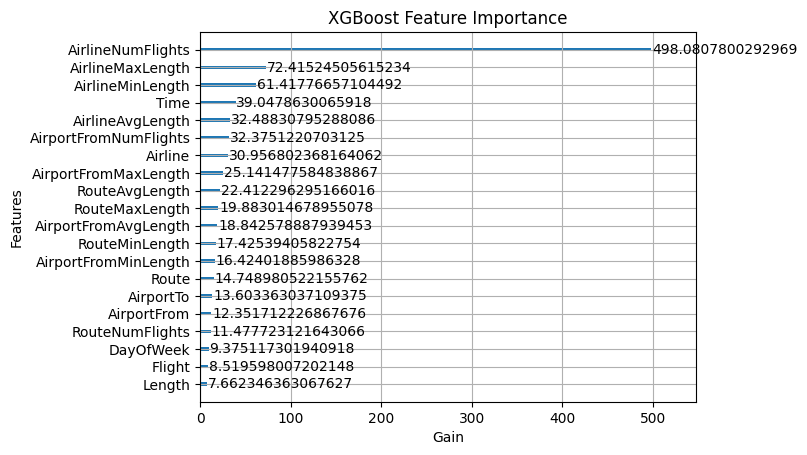

In [165]:
# Plot XGBoost feature importance
plt.figure(figsize=(12, 8))
plot_importance_xgb(xgb_model, importance_type='gain', title='XGBoost Feature Importance', xlabel='Gain')
plt.show()

<Figure size 1200x800 with 0 Axes>

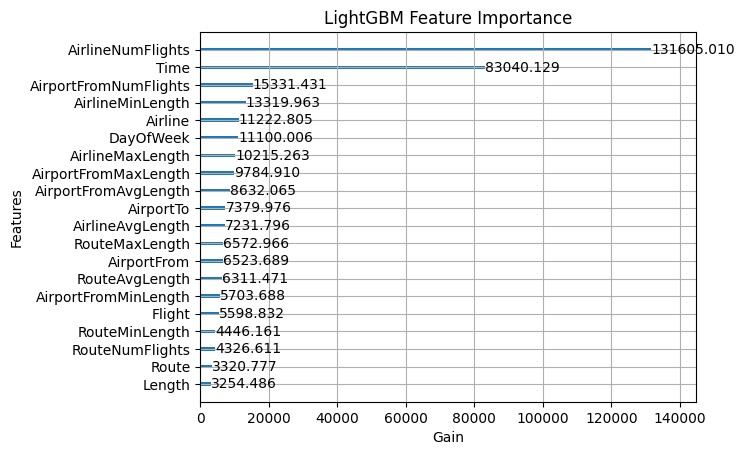

In [166]:
# Plot LightGBM feature importance
plt.figure(figsize=(12, 8))
plot_importance_lgbm(lgbm_model, importance_type='gain', title='LightGBM Feature Importance', xlabel='Gain')
plt.show()

In [195]:
# Define a function to plot confusion matrix for train and test
def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    # Extract model name from model instance
    model_name = type(model).__name__
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate confusion matrices for train and test
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    labels = sorted(set(y_train + y_pred_train))
    
    # Create subplots for train and test confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot train confusion matrix
    sns.heatmap(cm_train, 
                annot=True, 
                cmap="Blues", 
                fmt="d", 
                cbar=False, 
#                 xticklabels=labels, 
#                 yticklabels=labels, 
                ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title(f'Train: {model_name}')
    
    # Plot test confusion matrix
    sns.heatmap(cm_test, 
                annot=True, 
                cmap="Blues", 
                fmt="d", 
                cbar=False, 
#                 xticklabels=labels, 
#                 yticklabels=labels, 
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title(f'Test: {model_name}')
    
    #plt.tight_layout()
    plt.show()

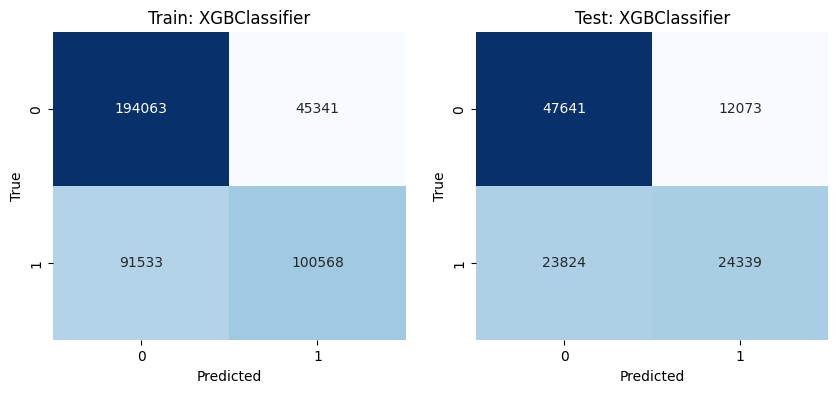

In [196]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, xgb_model)

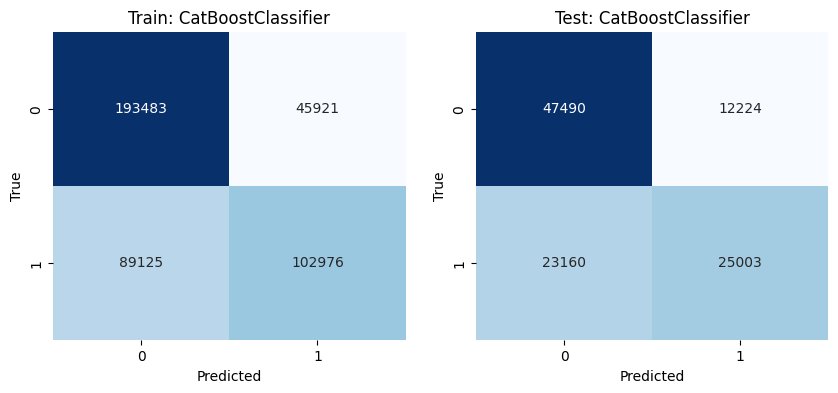

In [197]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, catboost_model)

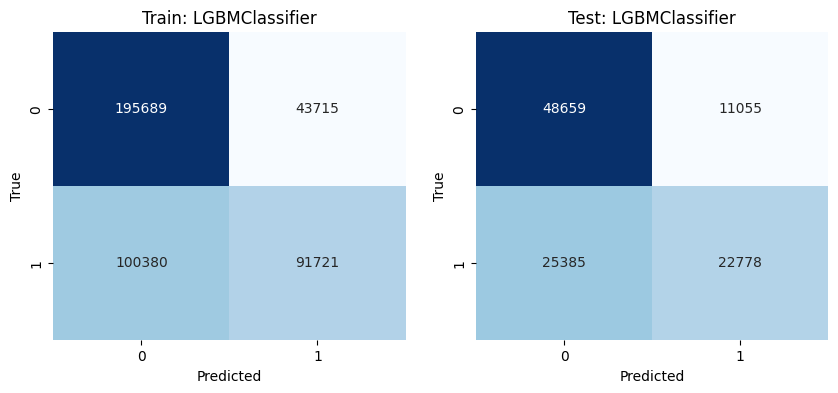

In [198]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, lgbm_model)